## Understanding grids: why they are important, what they are and how to use them

This tutorial runs through the theory and use of MOM6 (ACCESS-OM3) and  MOM5 (ACCESS-OM2) grids.

We also show how `XGCM` is a useful Python package for doing vector calculus on staggered grids.

For context, this tutorial is particularly useful if you'd like to 
 - https://cosima-recipes.readthedocs.io/en/latest/03-Mains/Relative_Vorticity.html
 - https://cosima-recipes.readthedocs.io/en/latest/03-Mains/Along-slope-velocities.html

### Why are they important?

[insert Navid's example picture]




### MOM6 ocean model grid (ACCESS-OM3) 

The following is from [here](https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/getting_started.html#Building-an-xgcm-grid-object) and [here](https://mom6.readthedocs.io/en/dev-gfdl/api/generated/pages/Discrete_Grids.html#horizontal-grids):
 - MOM6 variables are staggered according to the Arakawa C-grid
 - It uses a north-east index convention
 - center points are labelled (xh, yh) and corner points are labelled (xq, yq)
 - important: variables xh/yh, xq/yq that are named “nominal” longitude/latitude are not the true geographical coordinates and are not suitable for plotting (more later)

### MOM5 ocean model grid (ACCESS-OM2) 


Source

[MOM5 source code link](https://github.com/mom-ocean/MOM5/blob/6bdbdd4892543bbade921fa3224b2530d93c6f40/src/mom5/ocean_core/ocean_grids.F90#L437-L494)

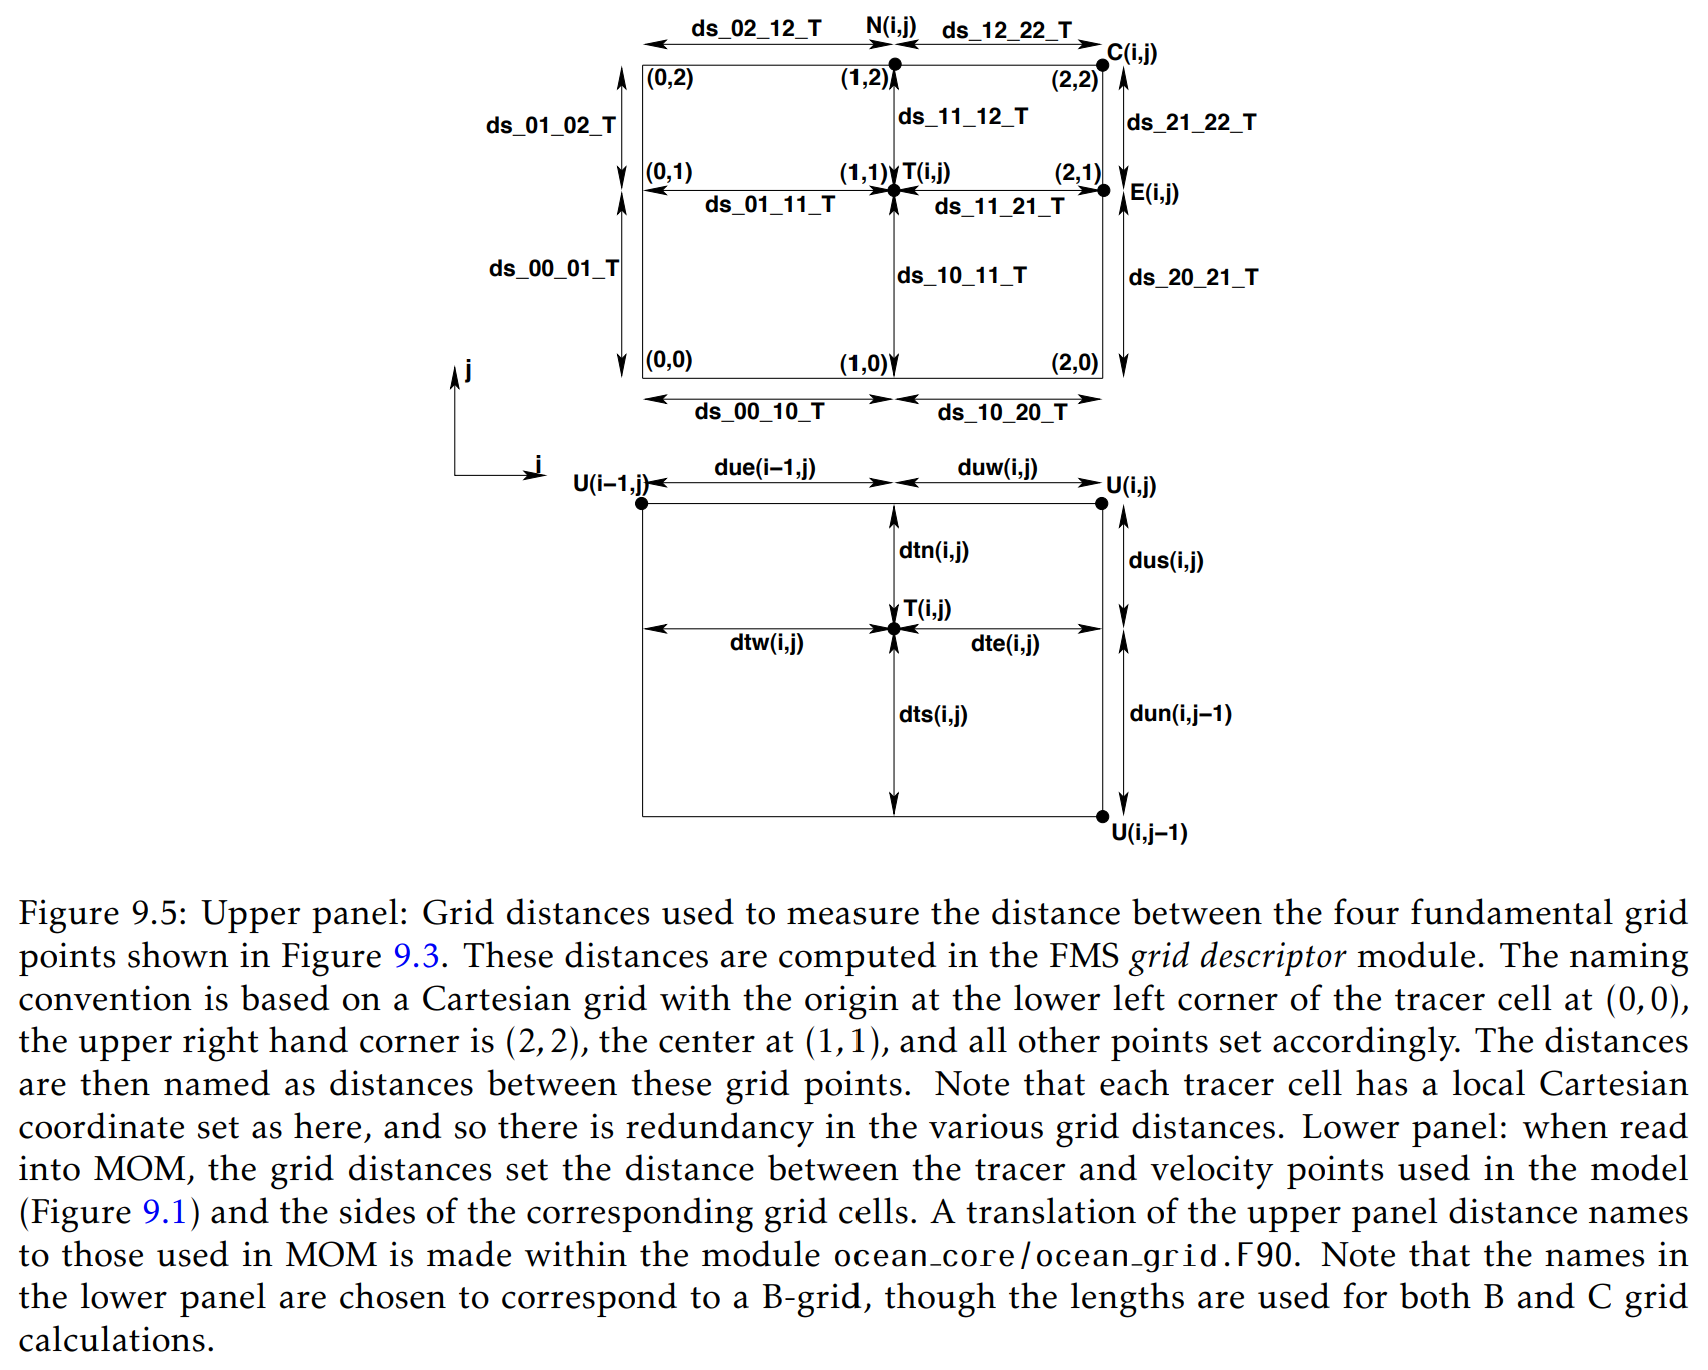

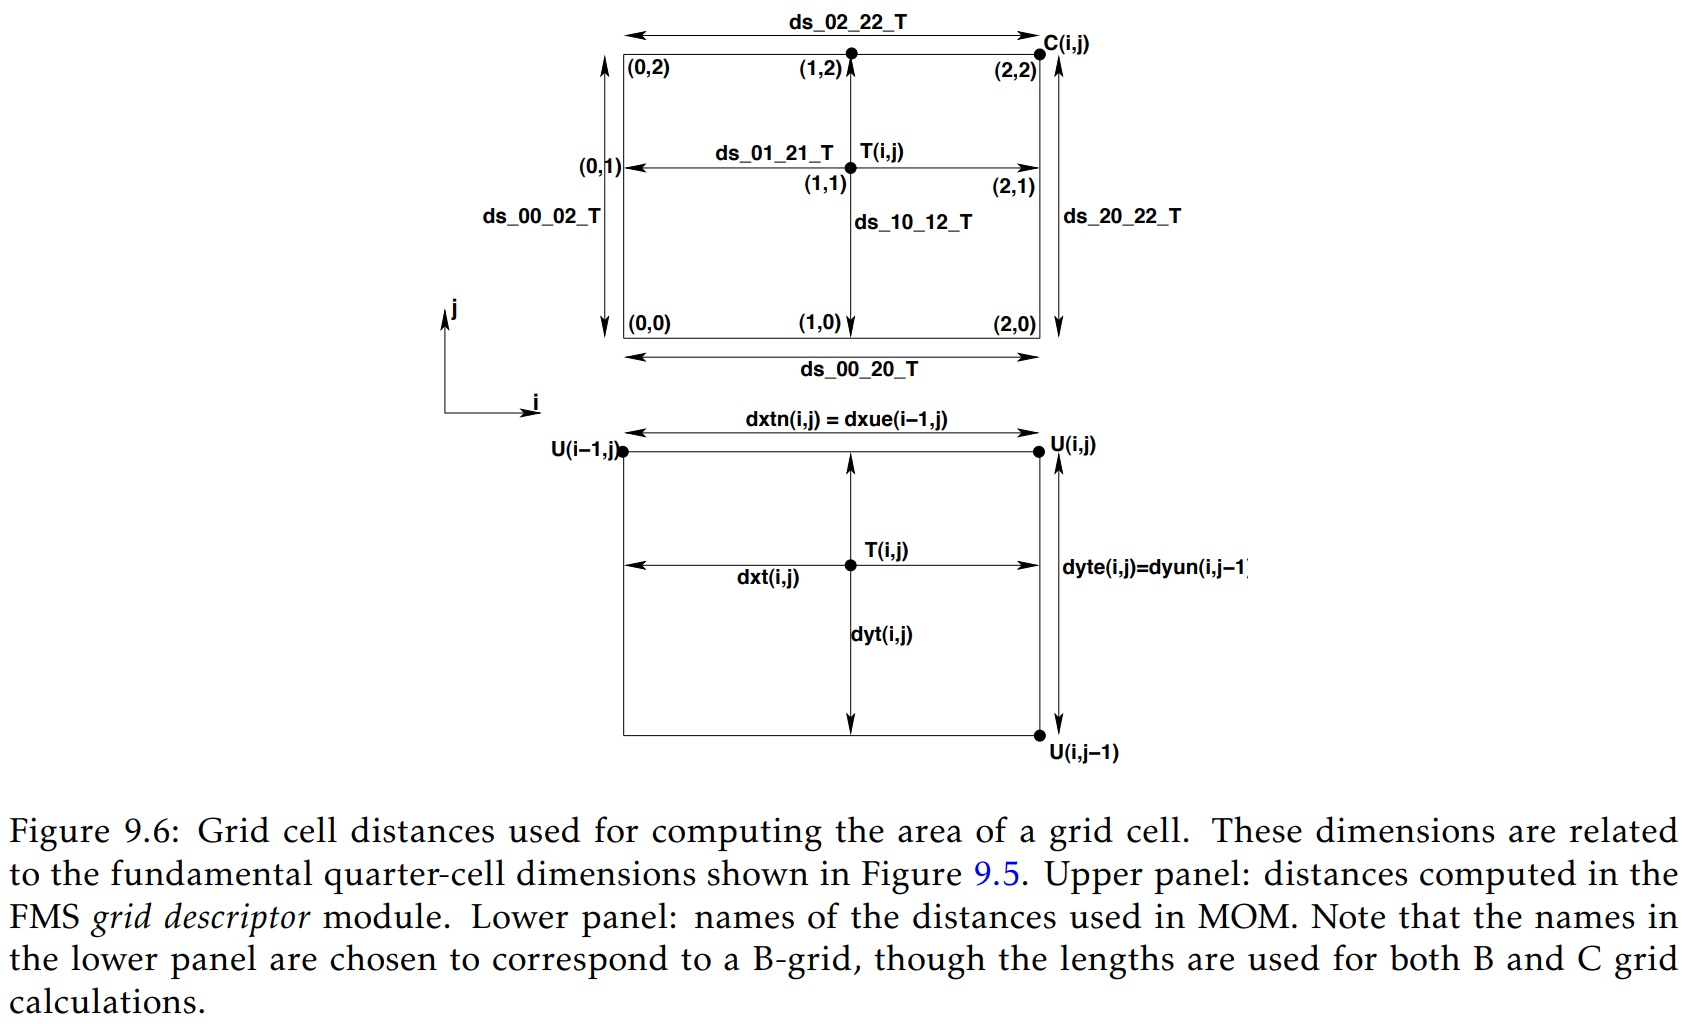

### XGCM

Idea how speed is trivial in mom5 not mom6 and vice versa. Then do vorticity and it's the other way around!

In [ ]:
# for non-symmetric
# SYMMETRIC_MEMORY_ = False
# see https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#xgcm-grid-definition
# and https://xgcm.readthedocs.io/en/latest/grid_metrics.html#Using-metrics-with-xgcm
grid = xgcm.Grid(static,
                 coords={'X': {'center': 'xh', 'right': 'xq'},
                         'Y': {'center': 'yh', 'right': 'yq'},},
                         # 'Z': { 'inner': 'zl', 'outer': 'zi'}},
                 metrics = {
                        ('X',): ['dxt', 'dxCu', 'dxCv'], # X distances
                        ('Y',): ['dyt', 'dyCu', 'dyCv'], # Y distances
                        ('X', 'Y'): ['areacello', 'areacello_cu', 'areacello_cv', 'areacello_bu'] # Areas
                        },
                 periodic=['X'])